In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from TrackScrap import general as gen
from TrackScrap import TSPosition as tsp
from TrackScrap import TSPositionPlus as tspp
from TrackScrap import TrackScrap as tr

# Definitions 

In [2]:
d_data = Path.cwd().parent / 'data'
f_data = d_data / 'cut_LS1_190_2_2.csv'

# Estimate velocities 

In [3]:
# 0. load all particles 
vid = tr.IDTracker_TS(str(f_data))

In [4]:
# 1. exclude nans, low IDtracker-probability, and too short blocks
vid.exclude_nans()
vid.exclude_low_prob(0.5)

/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:89: RuntimeWarning: invalid value encountered in less
  there = np.where(dat < mind)


In [7]:
# create for every valid-Block a Data-object (contains speed, acceleration, NND, ...)
vid.make_data_plus(5, False)
# merge from all blocks the velocities
speed = vid.merge_Dat('s')

/home/klamser/Gitrepos/TrackScrap/TrackScrap/TSPosition.py:305: RuntimeWarning: invalid value encountered in arccos
  d_phi = np.arccos(np.sum(u[:-1] * u[1:], axis=1))


In [8]:
print(speed.shape)

(6683, 8)


Text(0,0.5,'frequency')

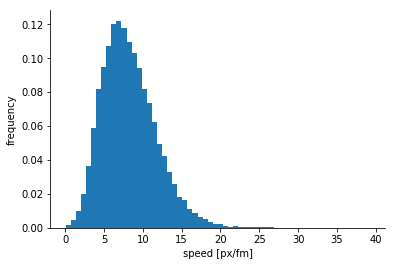

In [9]:
f, ax = plt.subplots(1)
_ = ax.hist(speed.flatten(), bins=60, density=True)
ax.set_xlabel('speed [px/fm]')
ax.set_ylabel('frequency')

In [10]:
meanSpeed = np.mean(speed)
maxSpeed = 30 # this should be set by your estimation

# original data interpolated at possible jumps 

## Load Data

(8907, 1, 2)


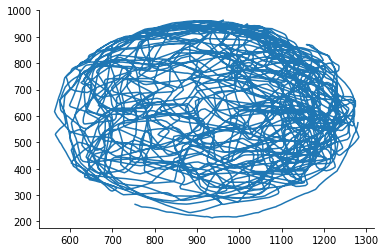

In [11]:
ID = 1
vid = tr.IDTracker_TS(str(f_data), ID)
vid.exclude_nans()
print(vid.dat.shape)
plt.plot(vid.dat[:, 0, 0], vid.dat[:, 0, 1])

## Exclude data with exclude_jumps
using the previously defined velocities

* Note that the function exclude_jumps is not perfect and does oversee small jumps because only large acceleration patterns will be detected
    * basically exclude_jumps uses the change in acceleration
* However, it is super easy to come up with a better function and implement it in TrackScrap
    * Thus the TrackScrap enables you to split the tracks in clean blocks

In [12]:
print('the valid blocks before the jumps are excluded:')
print(vid.v_block)
blocks = vid.exclude_jumps(maxSpeed, meanSpeed, returnBlocks=True)
print('the valid blocks after the jumps are excluded:', vid.v_block)

the valid blocks before the jumps are excluded:
[[   0  109]
 [ 213 8906]]
the valid blocks after the jumps are excluded: [[   0  109]
 [ 213  646]
 [ 652 2841]
 [2845 5673]
 [5677 8906]]


/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:118: RuntimeWarning: invalid value encountered in greater
  there = np.where(dat > mind)


### check excluded blocks
* Note that the examples here show the correct exclusion (red) in the first 2 and the last
* the third shows a normal startle response and should not be excluded
    * this demonstrate that the exlusion function is not perfect and needs correction

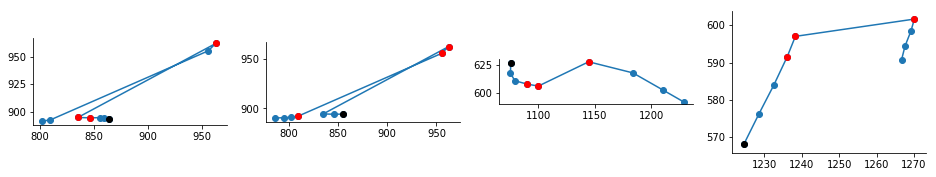

In [13]:
ID = 0
t_embed = 3
N = len(blocks)
f, axs = plt.subplots(1, N, figsize=plt.figaspect(1/N))
for i, block in enumerate(blocks):
    ax = axs[i]
    s = block[0] - t_embed
    e = block[1] + t_embed + 1
    da = vid.dat[s:e, ID].T
    ax.plot(da[0], da[1], marker='o')
    # mark the start black:
    ax.scatter(da[0, 0], da[1, 0], c='k', zorder=3)
    # mark the excluded stuff red:
    da = da[:, t_embed:-t_embed]
    ax.scatter(da[0], da[1], c='r', zorder=3)
    # ensure 
    ax.set_aspect('equal')

## Analyze the data 
TrackScrap contains some simple examples for group or individual measures as
* the area of the complex hull
* measured based on a smoothed trajectories

In [14]:
smoothWidth = 1 # in frames
smooth = True
vid.make_data_plus(smoothWidth, smooth)

Text(0,0.5,'speed [px/frame]')

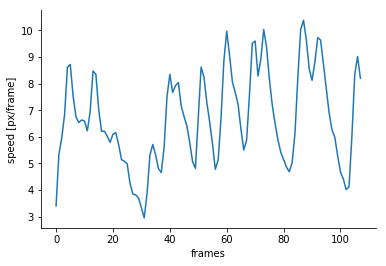

In [15]:
# now vid.Dat exists which contains for each valid-block an object (this can be costized if needed)
plt.plot(vid.Dat[0].s)
plt.xlabel('frames')
plt.ylabel('speed [px/frame]')

Text(0,0.5,'speed [px/frame]')

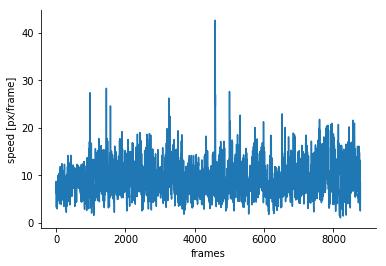

In [49]:
# if you want all speeds combined you can run
allSpeeds = vid.merge_Dat('s')
plt.plot(allSpeeds)
plt.xlabel('frames')
plt.ylabel('speed [px/frame]')

## Interpolate and compare the results
Note that interpolation should in general not be done. The data should just be excluded.

In [16]:
Nrows = len(vid.v_time) - 1
ori_dat = vid.dat.copy()
vid.interpolate_valid_blocks()

107 216
644 655
2839 2848
5671 5680


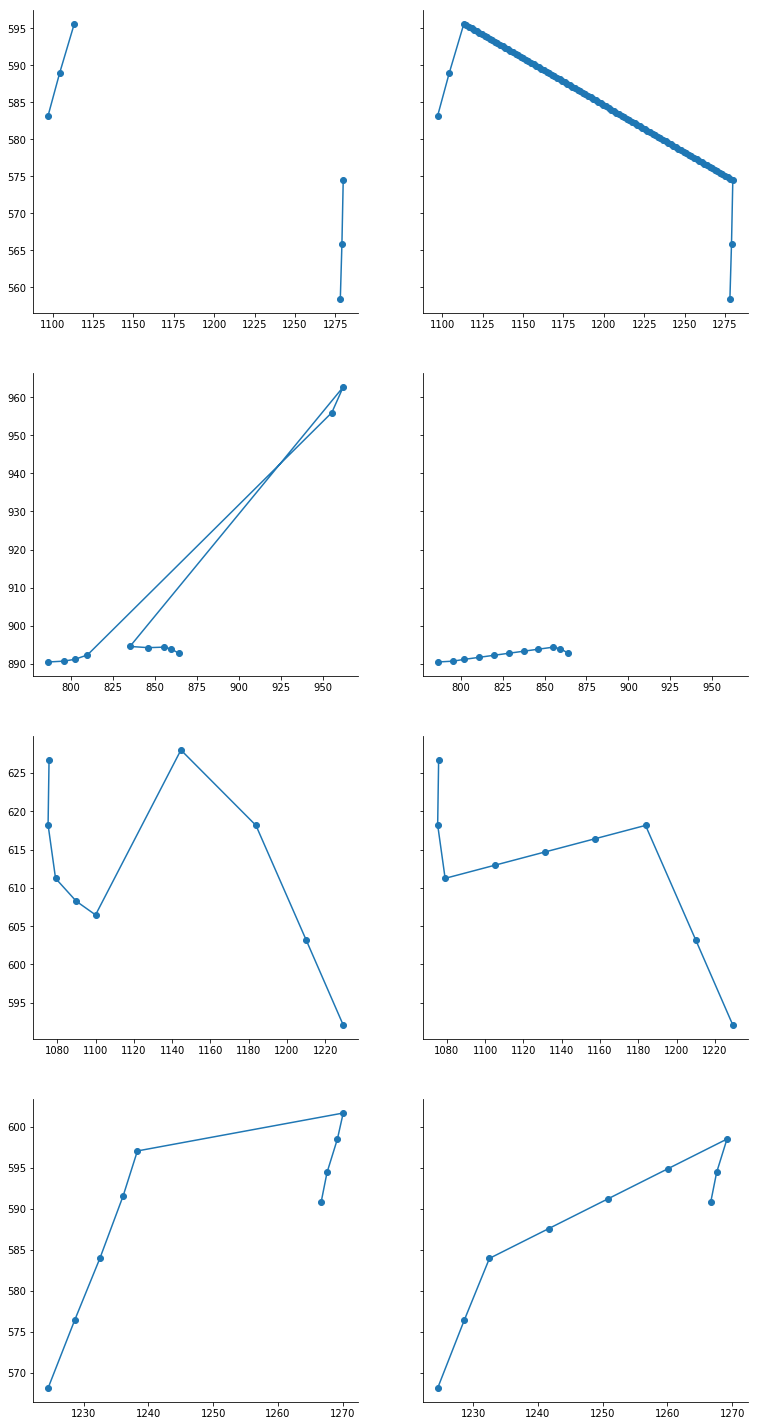

In [17]:
f, axs = plt.subplots(Nrows, 2, figsize=Nrows*0.8*plt.figaspect(Nrows/2),
                      sharex='row', sharey='row')
for i in range(Nrows):
    s = vid.v_block[i][1] - 2
    e = vid.v_block[i+1][0] + 3
    print(s, e)
    axs[i, 0].plot(ori_dat[s:e, 0, 0], ori_dat[s:e, 0, 1], marker='o')
    axs[i, 1].plot(vid.dat[s:e, 0, 0], vid.dat[s:e, 0, 1], marker='o')

## ToDo: Kalman Filter application   

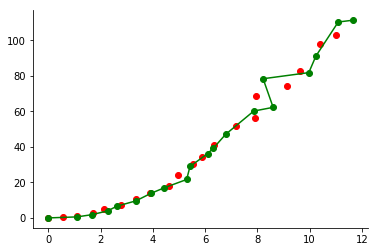

In [14]:
def kalman_xy(x, P, measurement, R,
              motion = np.matrix('0. 0. 0. 0.').T,
              Q = np.matrix(np.eye(4))):
    """
    Parameters:    
    x: initial state 4-tuple of location and velocity: (x0, x1, x0_dot, x1_dot)
    P: initial uncertainty convariance matrix
    measurement: observed position
    R: measurement noise 
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    """
    return kalman(x, P, measurement, R, motion, Q,
                  F = np.matrix('''
                      1. 0. 1. 0.;
                      0. 1. 0. 1.;
                      0. 0. 1. 0.;
                      0. 0. 0. 1.
                      '''),
                  H = np.matrix('''
                      1. 0. 0. 0.;
                      0. 1. 0. 0.'''))

def kalman(x, P, measurement, R, motion, Q, F, H):
    '''
    Parameters:
    x: initial state
    P: initial uncertainty convariance matrix
    measurement: observed position (same shape as H*x)
    R: measurement noise (same shape as H)
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    F: next state function: x_prime = F*x
    H: measurement function: position = H*x

    Return: the updated and predicted new values for (x, P)

    See also http://en.wikipedia.org/wiki/Kalman_filter

    This version of kalman can be applied to many different situations by
    appropriately defining F and H 
    '''
    # UPDATE x, P based on measurement m    
    # distance between measured and current position-belief
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I    # Kalman gain
    x = x + K*y
    I = np.matrix(np.eye(F.shape[0])) # identity matrix
    P = (I - K*H)*P

    # PREDICT x, P based on motion
    x = F*x + motion
    P = F*P*F.T + Q

    return x, P

def demo_kalman_xy():
    x = np.matrix('0. 0. 0. 0.').T 
    P = np.matrix(np.eye(4))*1000 # initial uncertainty

    N = 20
    true_x = np.linspace(0.0, 10.0, N)
    true_y = true_x**2
    noise = np.ones(len(true_x))
    observed_x = true_x + 0.1*np.random.random(N)*true_x
    observed_y = true_y + 0.1*np.random.random(N)*true_y
    plt.plot(observed_x, observed_y, 'ro')
    result = []
    R = 0.01**2
    for meas in zip(observed_x, observed_y):
        x, P = kalman_xy(x, P, meas, R)
        result.append((x[:2]).tolist())
    kalman_x, kalman_y = zip(*result)
    plt.plot(kalman_x, kalman_y, 'go-')
    plt.show()

demo_kalman_xy()